# Predicting the pandemic with Random Forests

In this notebook we are learning how to use random forest models in order to model the COVID19 pandemic and make forecasts.

In [1]:
# Define data paths (update these to match your local setup)
data_relative_dir_path = "/Users/ashok/Documents/ABROAD-NEW-INTAKE/SRH-MUNICH/COURSE-&-CLASS-RESOURCES/INTRO-ML/rki-merged-data/"

# File paths
owid_path = data_relative_dir_path + "compact.csv"

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# 1. LOAD & ENGINEER DATA (Recap)
# url = "data/owid_compact.csv"
url = owid_path
df = pd.read_csv(url)

df['date'] = pd.to_datetime(df['date'])
df = df[df['country'] == 'United Kingdom'].set_index('date').sort_index()

print(df.columns.tolist())
display(df.head())

df = df.loc['2020-10-01':'2022-03-01', 
            ['new_cases', 'new_deaths', 'hosp_patients', 'people_fully_vaccinated_per_hundred', 'icu_patients', 
             'reproduction_rate', 'stringency_index', 'gdp_per_capita', 'population_density', 'excess_mortality', 
             'new_vaccinations', 'new_vaccinations_smoothed']].fillna(0)

# Feature Engineering
df['cases_lag_14'] = df['new_cases'].shift(14)        # The Driver
df['hosp_lag_7'] = df['hosp_patients'].shift(7)      # Leading Indicator
df['hosp_lag_14'] = df['hosp_patients'].shift(14)     # Leading Indicator

# df['cases_smooth_7'] = df['new_cases'].rolling(7).mean() # The Trend

# df['velocity'] = df['cases_smooth_7'].pct_change(7)   # The Physics
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int) # The Cycle
df['day_of_week'] = df.index.dayofweek   

# 7-Day Rolling Average
df['cases_rolling_7'] = df['new_cases'].rolling(window=7).mean()
 
# Case Fatality Rate (CFR) - deaths / cases (as percentage)
# Using smoothed data for both
df['deaths_rolling_7'] = df['new_deaths'].rolling(window=7).mean()
df['cfr'] = (df['deaths_rolling_7'] / df['cases_rolling_7']) * 100# The Cycle  

df['deaths_trend_14'] = df['new_deaths'].rolling(14).mean()
df['cases_trend_7'] = df['new_cases'].rolling(7).mean()
 


# Current indicators
df['stringency'] = df['stringency_index'].fillna(0)

# Lagged features (14-day biological delay)
df['icu_patients_lag_7'] = df['icu_patients'].shift(7)
df['icu_patients_lag_14'] = df['icu_patients'].shift(14)
# print(f"   Hospital lag 14d: {df['icu_patients_lag_14'].isnull().sum()} NaN (first 14 days)")

# # 🔧 FIX #1: Fill vaccination rate with 0 (pre-vaccine era)
df['vaccination_rate'] = df['people_fully_vaccinated_per_hundred'].fillna(0)
# df['vaccination_rate'] = df['people_fully_vaccinated_per_hundred']

# SMOOTHED TARGET - reduces noise from reporting delays & weekend effects
df['deaths_smooth_7'] = df['new_deaths'].rolling(7, center=True).mean()


# 1. LOG-SPACE FEATURES (handles exponential dynamics)
df['log_cases_lag_14'] = np.log1p(df['new_cases'].shift(14))
df['log_hosp_lag_7'] = np.log1p(df['hosp_patients'].shift(7))

# 2. GROWTH RATES (scale-invariant — critical for generalization)
df['cases_growth_7d'] = df['new_cases'].shift(7) / df['new_cases'].shift(14).replace(0, np.nan)
df['deaths_growth_7d'] = df['new_deaths'].shift(7) / df['new_deaths'].shift(14).replace(0, np.nan)

# 3. ACCELERATION (detects turning points)
df['cases_accel'] = df['cases_growth_7d'] / df['cases_growth_7d'].shift(7).replace(0, np.nan)

# 4. HOSPITAL-TO-DEATH RATIO (proxy for healthcare strain)
df['hosp_death_ratio'] = df['new_deaths'].shift(7) / df['hosp_patients'].shift(14).replace(0, np.nan)



df = df.dropna()
display('after dropping na', df.head())


features = [
    # 'cases_lag_14', 
    'vaccination_rate', 
    'hosp_patients',
    'cfr',
    'icu_patients',
    'deaths_trend_14',
	# 'cases_accel',
    # 'deaths_growth_7d',
	# 'hosp_death_ratio'
    ]

# 2. SPLIT DATA (Time-Based)
# --------------------------
# Train on Waves 1-3, Test on Omicron
# cutoff = '2021-11-01'

# working features = ['cases_lag_14', 'vaccination_rate', 'hosp_patients','cfr','icu_patients','deaths_trend_14',]

# features = [
#     # 'hosp_lag_7', 
#     # 'cases_smooth_7', 
#     'cases_lag_14', 
#     # 'hosp_lag_14', 
#     'vaccination_rate', 
#     # 'icu_patients_lag_7',
#     # 'icu_patients_lag_14'
#     'hosp_patients',
#     'cfr',
#     # 'new_cases',
#     'icu_patients',
#     'deaths_trend_14',
#     # 'cases_trend_7'
#     ]


print(f"✅ Data processed")
print(f"   Missing values after processing: {df['new_deaths'].isnull().sum()}")



# print("🔧 Creating temporal features with biological delays...\n")
 
# # Current indicators
# df['reproduction_rate_current'] = df['reproduction_rate'].fillna(0)
# df['stringency'] = df['stringency_index'].fillna(0)
 
# # 🔧 FIX #1: Fill vaccination rate with 0 (pre-vaccine era)
# df['vaccination_rate'] = df['people_fully_vaccinated_per_hundred'].fillna(0)
# print(f"✅ Vaccination rate: {df['vaccination_rate'].isnull().sum()} NaN (fixed with 0)")
 
# # Lagged features (14-day biological delay)
# df['hosp_patients_lag_14'] = df['hosp_patients'].shift(14)
# df['icu_patients_lag_14'] = df['icu_patients'].shift(14)
# df['cases_lag_14'] = df['new_cases'].shift(14)
# print(f"   Hospital lag 14d: {df['hosp_patients_lag_14'].isnull().sum()} NaN (first 14 days)")
 
# # additional updates
# df['new_deaths_lag_14'] = df['new_deaths'].shift(14)
# df['icu_patients_lag_14_filled'] = df['icu_patients_lag_14'].fillna(0)
 
# # Rolling averages (smooth weekend effects)
# df['deaths_trend_14'] = df['new_deaths'].rolling(14).mean()
# df['cases_trend_7'] = df['new_cases'].rolling(7).mean()
# print(f"   Deaths trend 14d: {df['deaths_trend_14'].isnull().sum()} NaN (first 13 days)")
 
# # Static features
# df['gdp_per_capita'] = df['gdp_per_capita']
# df['population_density'] = df['population_density']
 
print("\n✅ Feature engineering complete")

# df = df.dropna()

print(f"✅ Selected time period: {len(df)} rows")
print(f"\nMissing values per column:")
print(df.isnull().sum())

df = df.fillna(0)

# 2. SPLIT DATA (Time-Based)
# --------------------------
# Train on Waves 1-3, Test on Omicron
cutoff = '2022-01-01'

# Compare: raw vs smoothed target
#target_raw = 'new_deaths'
# target_smooth = 'deaths_smooth_7'
target_smooth = 'new_deaths'

train = df[df.index < cutoff]
test = df[df.index >= cutoff]

X_train, y_train = train[features], train[target_smooth]
X_test, y_test = test[features], test[target_smooth]

print(f"Training Days: {len(X_train)}, Testing Days: {len(X_test)}")


['country', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'excess_mortality', 'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'icu_patients', 'icu_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'stringency_index', 'reproduction_rate', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_v

,country,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths,new_deaths,new_deaths_smoothed,...,population,population_density,median_age,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68179315.0,281.814209,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN
2020-01-02,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68179315.0,281.814209,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN
2020-01-03,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68179315.0,281.814209,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN
2020-01-04,United Kingdom,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,68179315.0,281.814209,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN
2020-01-05,United Kingdom,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,68179315.0,281.814209,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN


'after dropping na'

,new_cases,new_deaths,hosp_patients,people_fully_vaccinated_per_hundred,icu_patients,reproduction_rate,stringency_index,gdp_per_capita,population_density,excess_mortality,...,icu_patients_lag_7,icu_patients_lag_14,vaccination_rate,deaths_smooth_7,log_cases_lag_14,log_hosp_lag_7,cases_growth_7d,deaths_growth_7d,cases_accel,hosp_death_ratio
date,,,,,,,,,,,,,,,,,,,,,
2020-10-22,25613.0,210.0,8090.0,0.0,708.0,1.2025,67.59,47587.167969,281.814209,0.000000,...,581.0,436.0,0.0,207.857143,9.755625,8.661467,1.108174,1.416667,0.665932,0.029982
2020-10-23,25714.0,232.0,8653.0,0.0,744.0,1.1894,75.00,47587.167969,281.814209,0.000000,...,592.0,440.0,0.0,212.571429,9.829518,8.720624,1.072525,1.109091,0.734361,0.030034
2020-10-24,23475.0,242.0,9019.0,0.0,788.0,1.1770,75.00,47587.167969,281.814209,0.000000,...,614.0,469.0,0.0,225.142857,9.821518,8.758255,1.009824,1.567010,0.732060,0.035874
2020-10-25,21694.0,225.0,9538.0,0.0,828.0,1.1649,75.00,47587.167969,281.814209,10.388151,...,630.0,477.0,0.0,237.857143,9.673697,8.800717,1.127226,1.687500,0.982608,0.035644
2020-10-26,16434.0,219.0,9865.0,0.0,853.0,1.1541,75.00,47587.167969,281.814209,0.000000,...,658.0,507.0,0.0,248.571429,9.445333,8.873048,1.176629,1.738318,1.085367,0.038557


✅ Data processed
   Missing values after processing: 0

✅ Feature engineering complete
✅ Selected time period: 493 rows

Missing values per column:
new_cases                              0
new_deaths                             0
hosp_patients                          0
people_fully_vaccinated_per_hundred    0
icu_patients                           0
reproduction_rate                      0
stringency_index                       0
gdp_per_capita                         0
population_density                     0
excess_mortality                       0
new_vaccinations                       0
new_vaccinations_smoothed              0
cases_lag_14                           0
hosp_lag_7                             0
hosp_lag_14                            0
is_weekend                             0
day_of_week                            0
cases_rolling_7                        0
deaths_rolling_7                       0
cfr                                    0
deaths_trend_14                 

Data ready for advanced machine learning models. Rows: 493


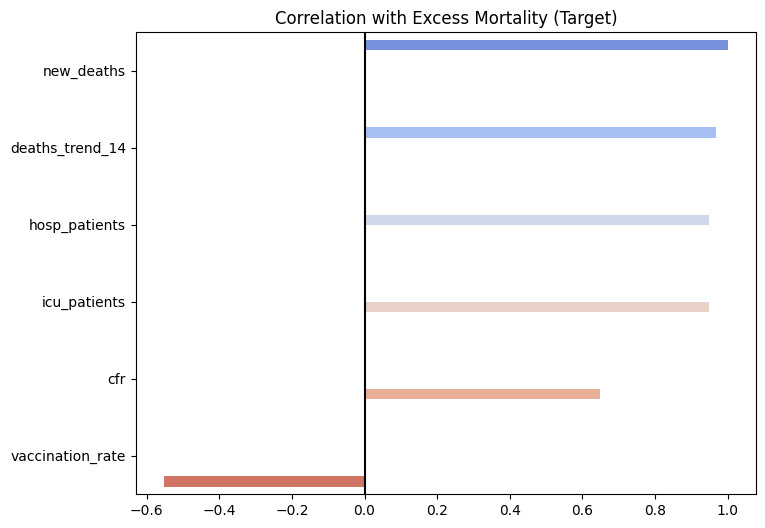

In [207]:
# 🔧 FIX: Use df_clean (from Cell 17) instead of df.dropna()
df_clean = df.dropna()
target = target_smooth
df_model = df_clean[features + [target]].copy()

print(f"Data ready for advanced machine learning models. Rows: {len(df_model)}")

# CHECK: Which feature is actually best?
# We correlate everything with our target ('new_deaths')
corr = df_model.corr()['new_deaths'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr.values, y=corr.index, hue=corr.index, palette='coolwarm')
plt.legend([],[], frameon=False)
plt.title("Correlation with Excess Mortality (Target)")
plt.axvline(0, color='black')
plt.show()

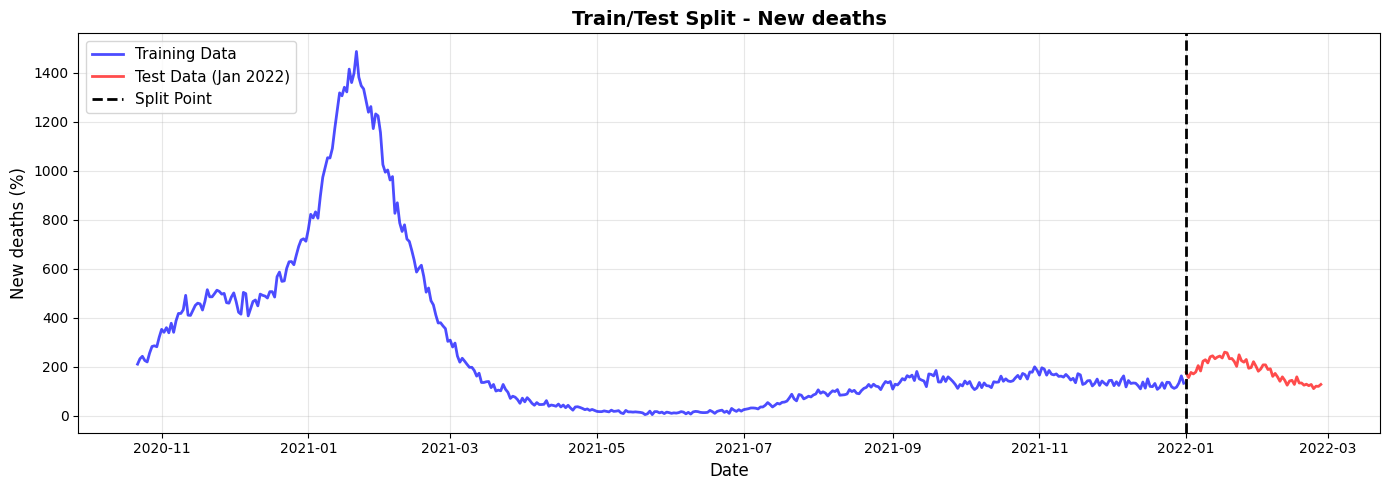

In [208]:

target = target_smooth
target_label = target_smooth.replace('_', ' ').replace('-', ' ').capitalize()


# Visualize the split
plt.figure(figsize=(14, 5))
plt.plot(train.index, train[target], 'b-', linewidth=2, label='Training Data', alpha=0.7)
plt.plot(test.index, test[target], 'r-', linewidth=2, label='Test Data (Jan 2022)', alpha=0.7)
plt.axvline(pd.Timestamp(cutoff), color='black', linestyle='--', linewidth=2, label='Split Point')
plt.title(f'Train/Test Split - {target_label}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel(f'{target_label} (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 1. Baseline Model (Linear Regression)

### Goal: Establish performance benchmark
Advanced models must beat this simple baseline!

In [209]:
print("📊 Training Baseline: Linear Regression\n")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr_train = lr.predict(X_train)
y_pred_lr_test = lr.predict(X_test)

# Metrics
mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)
mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
r2_lr_test = r2_score(y_test, y_pred_lr_test)

print(f"✅ Linear Regression Results:")
print(f"   Train MAE: {mae_lr_train:.3f}")
print(f"   Test MAE:  {mae_lr_test:.3f} ⭐ BASELINE")
print(f"   Test RMSE: {rmse_lr_test:.3f}")
print(f"   Test R²:   {r2_lr_test:.3f}")

📊 Training Baseline: Linear Regression

✅ Linear Regression Results:
   Train MAE: 22.045
   Test MAE:  47.189 ⭐ BASELINE
   Test RMSE: 52.482
   Test R²:   -0.484


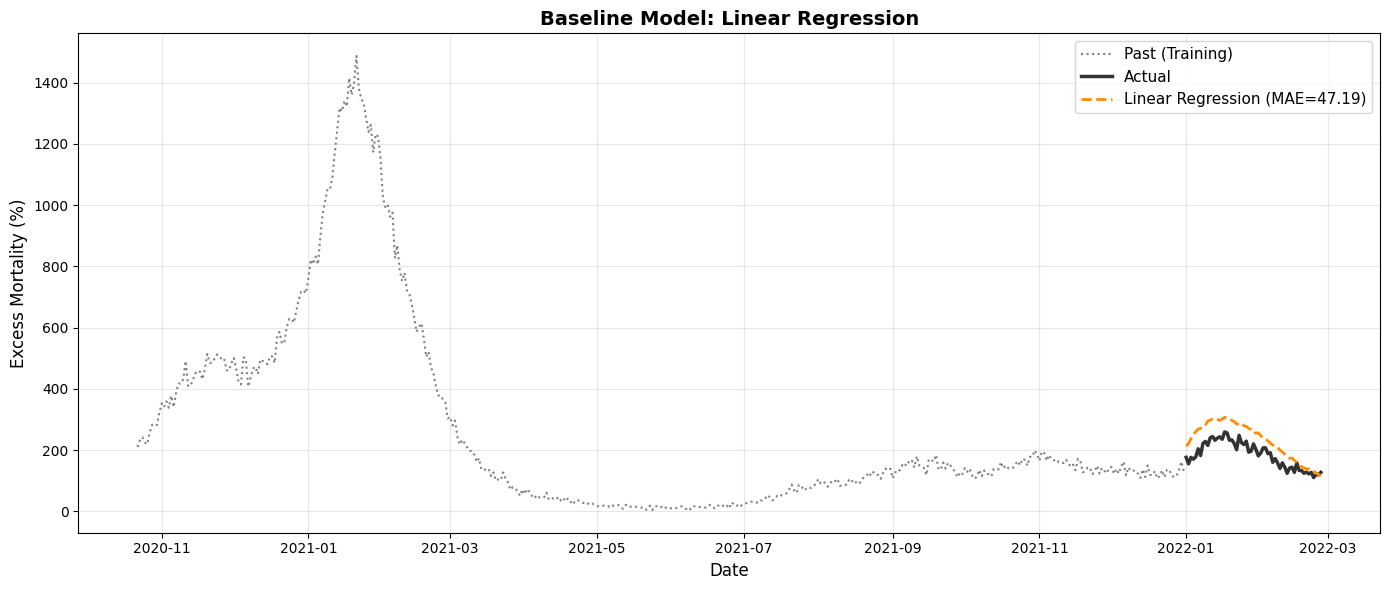

In [210]:
# Visualize baseline predictions
plt.figure(figsize=(14, 6))

# Plot the Past (Training Data) - Optional, for context
plt.plot(train.index, train[target], color='gray', linestyle=':', label='Past (Training)')

plt.plot(test.index, y_test, 'k-', linewidth=2.5, label='Actual', alpha=0.8)
plt.plot(test.index, y_pred_lr_test, color='darkorange', linestyle='--', linewidth=2, label=f'Linear Regression (MAE={mae_lr_test:.2f})')
plt.title('Baseline Model: Linear Regression', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Excess Mortality (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 2. Decision Tree (Depth Analysis)

### Experiment: Finding optimal tree depth
- Shallow trees underfit
- Deep trees overfit
- Goal: Find the "Goldilocks zone"

Now let's find how the depth of the decision tree influences its accuracy...

        Train MAE    Test MAE
Depth                        
1      125.394325  131.882177
2       63.418175  140.860170
3       29.528848  158.869567
4       18.815203  136.390305
8        5.330649  118.876201
16       0.025229  111.824561
32       0.000000  113.701754
None     0.000000  113.701754


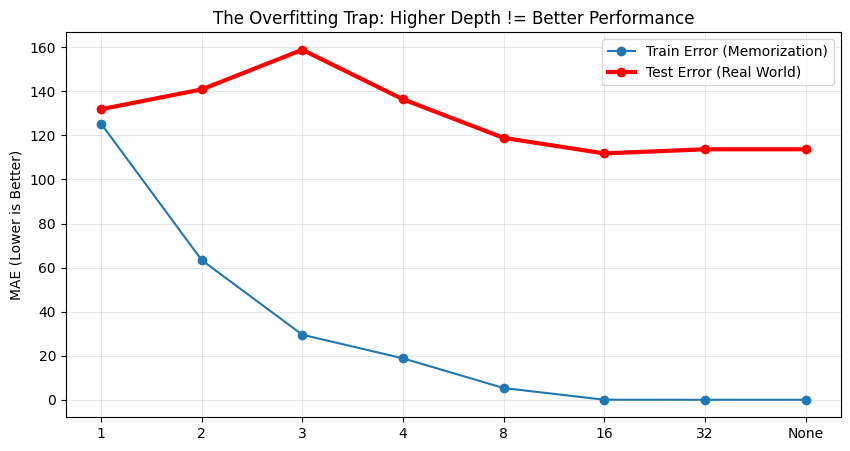

In [211]:
# THE EXPERIMENT: DEPTH SWEEP 
depths = [1, 2, 3, 4, 8, 16, 32, None]
results = []

for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    
    train_mae = mean_absolute_error(y_train, dt.predict(X_train))
    test_mae = mean_absolute_error(y_test, dt.predict(X_test))
    
    results.append({'Depth': str(d), 'Train MAE': train_mae, 'Test MAE': test_mae})

# Convert to DataFrame and Plot
res_df = pd.DataFrame(results).set_index('Depth')
print(res_df)

plt.figure(figsize=(10, 5))
plt.plot(res_df.index, res_df['Train MAE'], marker='o', label='Train Error (Memorization)')
plt.plot(res_df.index, res_df['Test MAE'], marker='o', color='red', linewidth=3, label='Test Error (Real World)')
plt.ylabel("MAE (Lower is Better)")
plt.title("The Overfitting Trap: Higher Depth != Better Performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [212]:
# Step B: Decision Tree - Use depth 8 (balanced)
dt = DecisionTreeRegressor(max_depth=8, random_state=42)
dt.fit(X_train, y_train)
mae_dt = mean_absolute_error(y_test, dt.predict(X_test))

# Step C: Random Forest - Tune based on depth experiment
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,  # Changed from None to 8 (prevents overfitting)
    min_samples_leaf=5,
    min_samples_split=10,  # Increased from 5 (more conservative)
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
mae_rf = mean_absolute_error(y_test, rf.predict(X_test))

# Step D: XGBoost - Add depth control
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=1000,
    # max_depth=6,  # Add depth limit (XGBoost default is 6)
    learning_rate=0.05,
    # min_child_weight=5,  # Similar to min_samples_leaf
    # subsample=0.8,  # Use 80% of data per tree (reduces overfitting)
    # colsample_bytree=0.8,  # Use 80% of features per tree
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

Let's see how a random forest performs in comparison...

Linear MAE:        47.19
Decision Tree MAE: 118.88
Random Forest MAE: 82.69
XGBoost MAE:       53.30


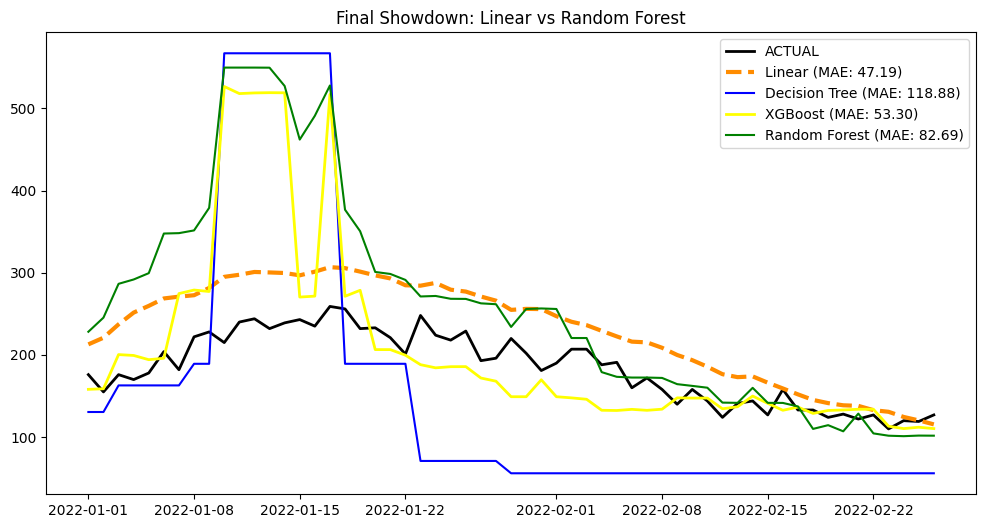

In [213]:
mae_lr = mae_lr_test

# Step A: Baseline (Linear Regression)
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# mae_lr = mean_absolute_error(y_test, lr.predict(X_test))

# # Step B: Decision Tree
# dt = DecisionTreeRegressor(max_depth=10, random_state=42)
# dt.fit(X_train, y_train)
# mae_dt = mean_absolute_error(y_test, dt.predict(X_test))

# # Step C: Random Forest
# rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_leaf=5, min_samples_split=5, random_state=42)
# rf.fit(X_train, y_train)
# mae_rf = mean_absolute_error(y_test, rf.predict(X_test))

# # Step D: XGBoost
# print("Training XGBoost...")
# from xgboost import XGBRegressor
# xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
# xgb.fit(X_train, y_train)

# EVALUATE
# # -----------
pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, pred_xgb)

# Note: `y_test` is actual value of target variable

print(f"Linear MAE:        {mae_lr:.2f}") 
print(f"Decision Tree MAE: {mae_dt:.2f}") 
print(f"Random Forest MAE: {mae_rf:.2f}") 
print(f"XGBoost MAE:       {mae_xgb:.2f}")

# Visualization
pred_rf = rf.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, color='black', label='ACTUAL', linewidth=2)
plt.plot(test.index, lr.predict(X_test), color='darkorange', linewidth=3, linestyle='--', label=f'Linear (MAE: {mae_lr:.2f})')
plt.plot(test.index, dt.predict(X_test), color='blue', label=f'Decision Tree (MAE: {mae_dt:.2f})')

plt.plot(test.index, pred_xgb, color='yellow', linewidth=2, label=f'XGBoost (MAE: {mae_xgb:.2f})')


plt.plot(test.index, pred_rf, color='green', label=f'Random Forest (MAE: {mae_rf:.2f})')
plt.title("Final Showdown: Linear vs Random Forest")
plt.legend()
plt.show()



# Opening the black box
# ---------------------

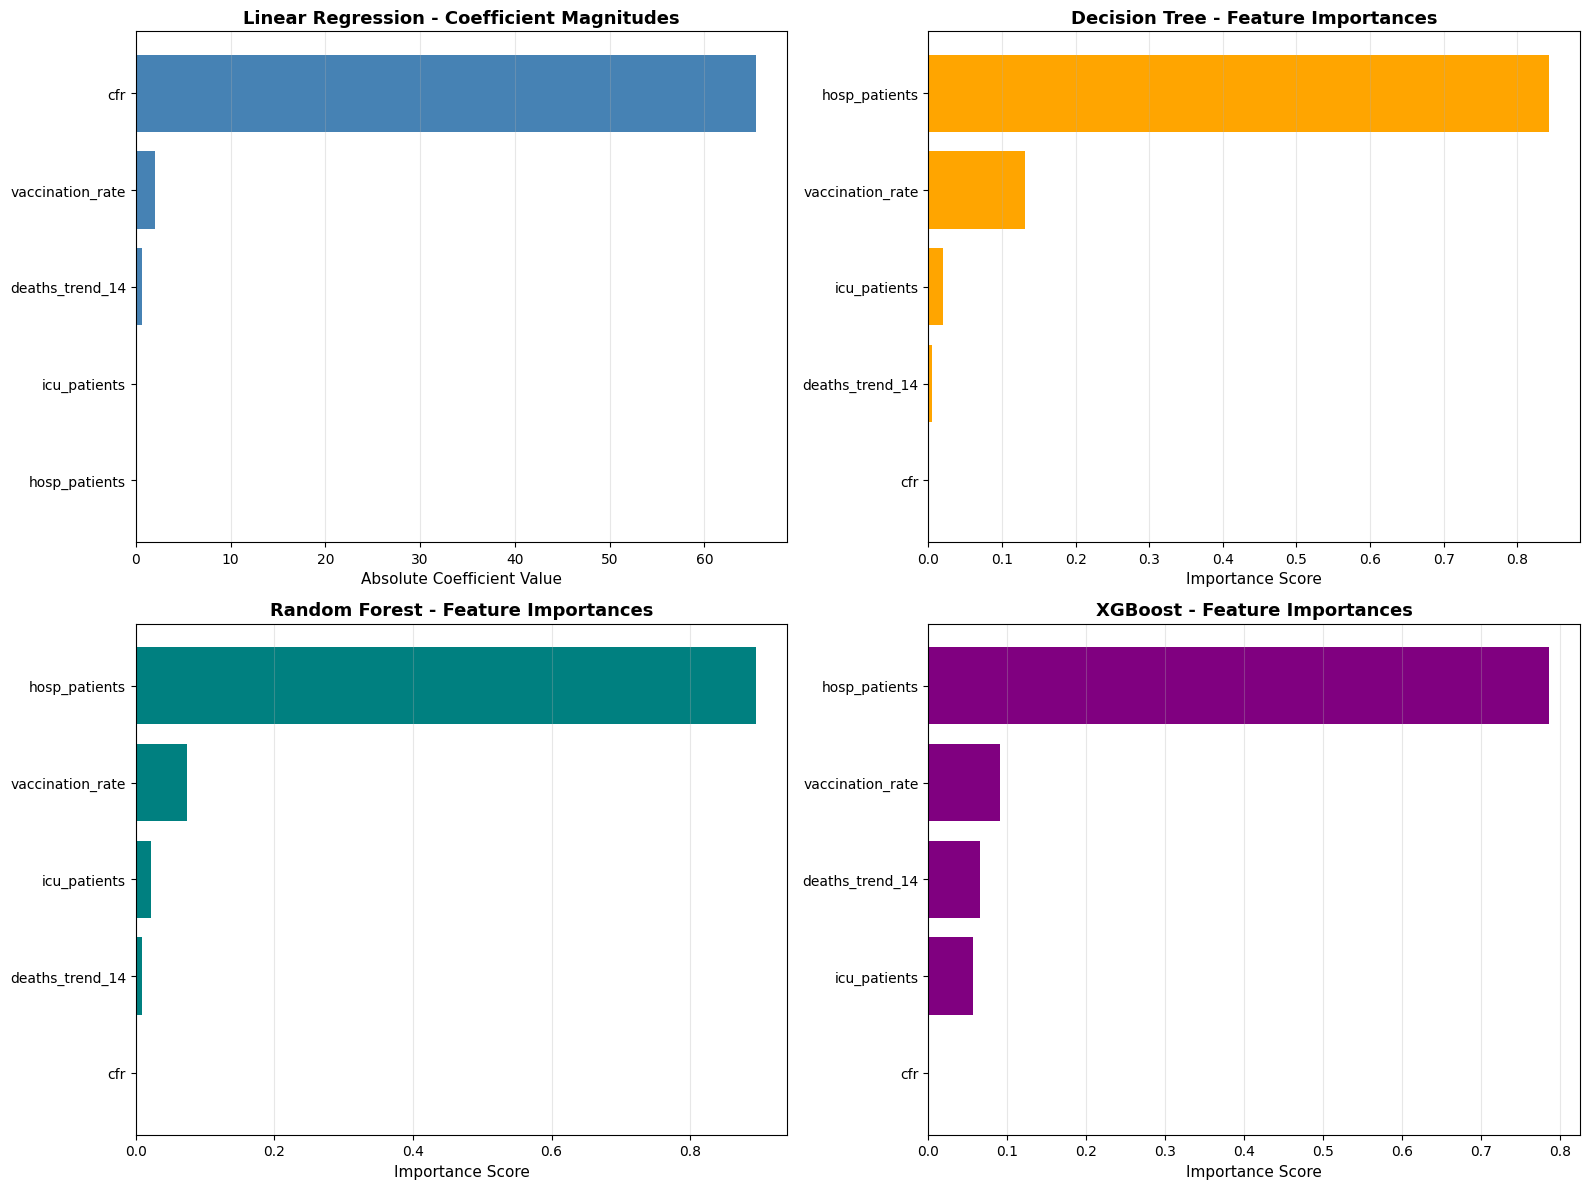


FEATURE IMPORTANCE RANKINGS ACROSS ALL MODELS
                  Linear Reg  Decision Tree  Random Forest  XGBoost  Avg Rank
hosp_patients              5              1              1        1       2.0
vaccination_rate           2              2              2        2       2.0
deaths_trend_14            3              4              4        3       3.5
icu_patients               4              3              3        4       3.5
cfr                        1              5              5        5       4.0

🏆 TOP 3 MOST IMPORTANT FEATURES (by average rank):
   1. hosp_patients (Avg Rank: 2.0)
   2. vaccination_rate (Avg Rank: 2.0)
   3. deaths_trend_14 (Avg Rank: 3.5)

💡 Interpretation:
   - Lower rank = More important (1 is most important)
   - Consensus across models indicates robust feature importance
   - Linear Reg uses coefficient magnitudes (different scale)


In [214]:
# # Opening the black box
# # ---------------------
# importances = pd.Series(rf.feature_importances_, index=features).sort_values()

# plt.figure(figsize=(8, 4))
# importances.plot(kind='barh', color='teal')
# plt.title("What matters most?")
# plt.xlabel("Feature Importance")
# plt.show()


# Feature Importance Comparison: All Models
# -----------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Linear Regression - Coefficient Magnitudes
lr_importances = pd.Series(np.abs(lr.coef_), index=features).sort_values()
axes[0, 0].barh(lr_importances.index, lr_importances.values, color='steelblue')
axes[0, 0].set_title('Linear Regression - Coefficient Magnitudes', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Absolute Coefficient Value', fontsize=11)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Decision Tree - Feature Importances
dt_importances = pd.Series(dt.feature_importances_, index=features).sort_values()
axes[0, 1].barh(dt_importances.index, dt_importances.values, color='orange')
axes[0, 1].set_title('Decision Tree - Feature Importances', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Importance Score', fontsize=11)
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Random Forest - Feature Importances
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values()
axes[1, 0].barh(rf_importances.index, rf_importances.values, color='teal')
axes[1, 0].set_title('Random Forest - Feature Importances', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Importance Score', fontsize=11)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. XGBoost - Feature Importances
xgb_importances = pd.Series(xgb.feature_importances_, index=features).sort_values()
axes[1, 1].barh(xgb_importances.index, xgb_importances.values, color='purple')
axes[1, 1].set_title('XGBoost - Feature Importances', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Importance Score', fontsize=11)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Table: Feature Rankings Across Models
print("\n" + "="*80)
print("FEATURE IMPORTANCE RANKINGS ACROSS ALL MODELS")
print("="*80)

importance_df = pd.DataFrame({
    'Linear Reg': lr_importances.rank(ascending=False).astype(int),
    'Decision Tree': dt_importances.rank(ascending=False).astype(int),
    'Random Forest': rf_importances.rank(ascending=False).astype(int),
    'XGBoost': xgb_importances.rank(ascending=False).astype(int)
})

# Sort by Random Forest ranking (or average ranking)
importance_df['Avg Rank'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values('Avg Rank')

print(importance_df)
print("="*80)

# Top 3 features by model consensus
print("\n🏆 TOP 3 MOST IMPORTANT FEATURES (by average rank):")
for i, (feat, row) in enumerate(importance_df.head(3).iterrows(), 1):
    print(f"   {i}. {feat} (Avg Rank: {row['Avg Rank']:.1f})")

print("\n💡 Interpretation:")
print("   - Lower rank = More important (1 is most important)")
print("   - Consensus across models indicates robust feature importance")
print("   - Linear Reg uses coefficient magnitudes (different scale)")
print("="*80)

Also let's compare with a gradient boosted tree...

Training XGBoost...
Random Forest MAE: 82.69
XGBoost MAE:       53.30
✅ XGBoost wins! It squeezed out more accuracy.


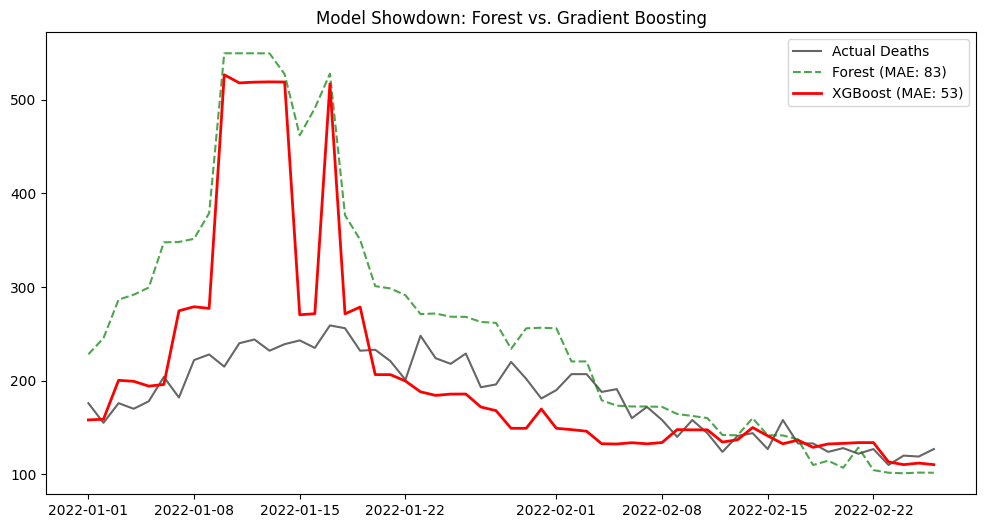

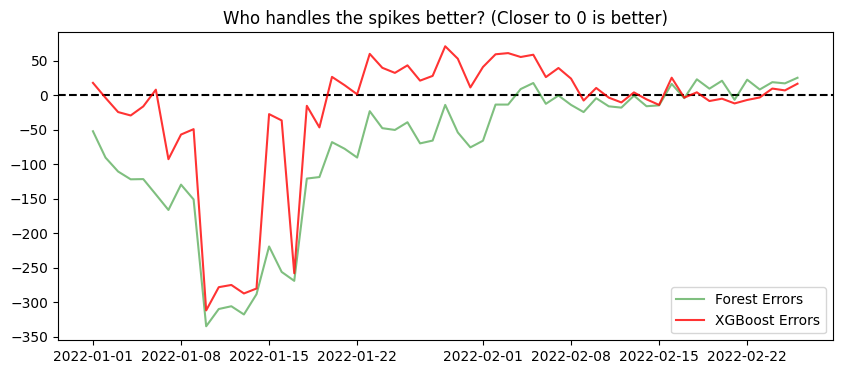

In [215]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

# TRAIN THE MODEL 
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)

print("Training XGBoost...")
xgb.fit(X_train, y_train)

# EVALUATE
# -----------
pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, pred_xgb)

print(f"Random Forest MAE: {mae_rf:.2f}") # From previous notebook
print(f"XGBoost MAE:       {mae_xgb:.2f}")

if mae_xgb < mae_rf:
    print("✅ XGBoost wins! It squeezed out more accuracy.")
else:
    print("❌ Tie/Loss. (XGBoost often needs more tuning to beat a Forest).")

# VISUALIZE
plt.figure(figsize=(12, 6))

# Plot Actual Data
plt.plot(test.index, y_test, color='black', alpha=0.6, label='Actual Deaths')

# Plot Random Forest (Green)
plt.plot(test.index, pred_rf, color='green', linestyle='--', alpha=0.7, label=f'Forest (MAE: {mae_rf:.0f})')

# Plot XGBoost (Red)
plt.plot(test.index, pred_xgb, color='red', linewidth=2, label=f'XGBoost (MAE: {mae_xgb:.0f})')

plt.title("Model Showdown: Forest vs. Gradient Boosting")
plt.legend()
plt.show()

# EXPLAINING THE "WHY" (Residual Plot)
# ---------------------------------------
# Let's see the errors. XGBoost should have smaller residuals on the "spikes".
residuals_rf = y_test - pred_rf
residuals_xgb = y_test - pred_xgb

plt.figure(figsize=(10, 4))
plt.axhline(0, color='black', linestyle='--')
plt.plot(test.index, residuals_rf, color='green', alpha=0.5, label='Forest Errors')
plt.plot(test.index, residuals_xgb, color='red', alpha=0.8, label='XGBoost Errors')
plt.title("Who handles the spikes better? (Closer to 0 is better)")
plt.legend()
plt.show()

## COMPREHENSIVE MODEL PERFORMANCE COMPARISON


In [216]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, y_true, y_pred):
    """Calculate all key metrics for a model"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE - avoid division by zero
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    return {
        'Model': name,
        'MAE ↓': f'{mae:.3f}',
        'RMSE ↓': f'{rmse:.3f}',
        'R² ↑': f'{r2:.3f}',
        'MAPE % ↓': f'{mape:.2f}'
    }
    
    
    

# Evaluate all models
results = []
results.append(evaluate_model('Linear Regression', y_test, lr.predict(X_test)))
results.append(evaluate_model('Decision Tree', y_test, dt.predict(X_test)))
results.append(evaluate_model('Random Forest', y_test, rf.predict(X_test)))
results.append(evaluate_model('XGBoost', y_test, xgb.predict(X_test)))

# Create comparison table
comparison_df = pd.DataFrame(results)
print(comparison_df.round(3))
print("\n" + "="*70)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Find best model per metric
print("\n🏆 BEST MODEL PER METRIC:")

# Quick fix - convert to numeric directly
print(f"   • Lowest MAE:  {comparison_df.loc[pd.to_numeric(comparison_df['MAE ↓']).idxmin(), 'Model']}")
print(f"   • Lowest RMSE: {comparison_df.loc[pd.to_numeric(comparison_df['RMSE ↓']).idxmin(), 'Model']}")
print(f"   • Highest R²:  {comparison_df.loc[pd.to_numeric(comparison_df['R² ↑']).idxmax(), 'Model']}")
print(f"   • Lowest MAPE: {comparison_df.loc[pd.to_numeric(comparison_df['MAPE % ↓'].str.replace('%', '')).idxmin(), 'Model']}")

print("\n💡 INTERPRETATION:")
print("   ↓ = Lower is better  |  ↑ = Higher is better")
print("   • MAE: Average absolute error")
print("   • RMSE: Penalizes large errors more than MAE")
print("   • R²: Variance explained (closer to 1.0 is better)")
print("   • MAPE: Percentage error (easier to interpret)")
print("="*70)

               Model    MAE ↓   RMSE ↓     R² ↑ MAPE % ↓
0  Linear Regression   47.189   52.482   -0.484    25.08
1      Decision Tree  118.876  152.120  -11.466    61.74
2      Random Forest   82.690  125.225   -7.448    39.52
3            XGBoost   53.296   96.995   -4.068    24.89

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
            Model   MAE ↓  RMSE ↓    R² ↑ MAPE % ↓
Linear Regression  47.189  52.482  -0.484    25.08
    Decision Tree 118.876 152.120 -11.466    61.74
    Random Forest  82.690 125.225  -7.448    39.52
          XGBoost  53.296  96.995  -4.068    24.89

🏆 BEST MODEL PER METRIC:
   • Lowest MAE:  Linear Regression
   • Lowest RMSE: Linear Regression
   • Highest R²:  Linear Regression
   • Lowest MAPE: XGBoost

💡 INTERPRETATION:
   ↓ = Lower is better  |  ↑ = Higher is better
   • MAE: Average absolute error
   • RMSE: Penalizes large errors more than MAE
   • R²: Variance explained (closer to 1.0 is better)
   • MAPE: Percentage error (easier to interpret)


/var/folders/yb/mfpcq1nj1_v1m00ygpk5rkj80000gp/T/ipykernel_6921/1073401770.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(models, rotation=45, ha='right')


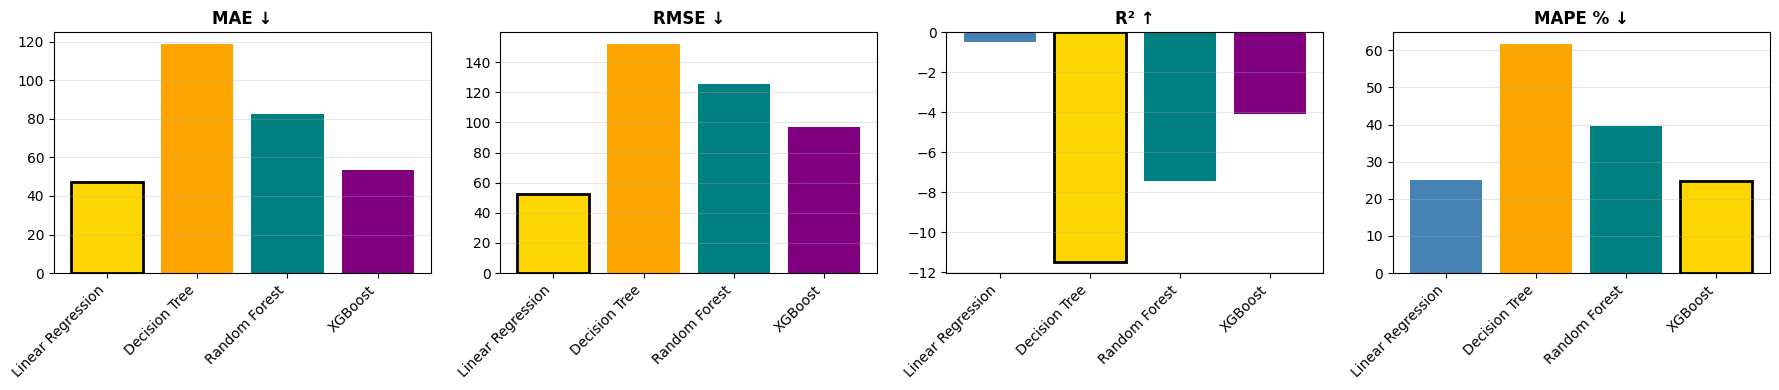

In [217]:
# Visual comparison of all metrics
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

metrics_data = {
    'MAE ↓': [float(r['MAE ↓']) for r in results],
    'RMSE ↓': [float(r['RMSE ↓']) for r in results],
    'R² ↑': [float(r['R² ↑']) for r in results],
    'MAPE % ↓': [float(r['MAPE % ↓'].replace('%', '')) for r in results]
}

models = [r['Model'] for r in results]
colors = ['steelblue', 'orange', 'teal', 'purple']

for idx, (metric, values) in enumerate(metrics_data.items()):
    axes[idx].bar(models, values, color=colors)
    axes[idx].set_title(f'{metric}', fontweight='bold')
    axes[idx].set_xticklabels(models, rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Highlight best
    if metric == 'R²':
        best_idx = np.argmax(values)
    else:
        best_idx = np.argmin(values)
    axes[idx].patches[best_idx].set_facecolor('gold')
    axes[idx].patches[best_idx].set_edgecolor('black')
    axes[idx].patches[best_idx].set_linewidth(2)

plt.tight_layout()
plt.show()